In [6]:
import datetime
from datetime import date
from datetime import datetime
import requests
import pprint
from bs4 import BeautifulSoup
import pandas as pd
import re
import pickle
from urllib.request import urlopen
import glob
# import altair as alt
import time
import itertools
import numpy as np
import operator
from datetime import timedelta
from ipywidgets import interact, IntSlider
from IPython.display import display
import sklearn
import numpy as np
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold

# pd.options.display.max_columns = 5000
# pd.options.display.max_rows = 5000

In [7]:
# Load Dataset

# Renzo's Path
# dataset = pd.read_csv('/Volumes/GoogleDrive/.shortcut-targets-by-id/1KUGn_35OjAoOP2puz6yG-2g_8LBxvDG_/SIADS 697 - Capstone/Dataframes/complete_final_df_5.csv')

# Sravan's Path
dataset = pd.read_csv('/Users/srav88/My Drive/SIADS 697 - Capstone/Dataframes/dataset_for_model_final.csv')

In [8]:
dataset.loc[(dataset['injury_count'].shift(1) == 1) & (dataset['injury_count'] == 1), 'drop'] = 1
dataset.loc[(dataset['injury_count'].shift(1) == 0) & (dataset['injury_count'] == 1), 'drop'] = 0
dataset.loc[(dataset['injury_count'].shift(1) == 1) & (dataset['injury_count'] == 0), 'drop'] = 0
dataset.loc[(dataset['injury_count'].shift(1) == 0) & (dataset['injury_count'] == 0), 'drop'] = 0
dataset.loc[(dataset['injury_count'] == 1) & (dataset['cum_week'] == 0), 'drop'] = 1

In [9]:
# dataset[dataset['FBRefID']=='dea698d9'].to_csv('/Users/srav88/My Drive/SIADS 697 - Capstone/Dataframes/ronaldo.csv', index=False)
dataset = dataset[dataset['drop'] == 0]

In [10]:
dataset["last_week"] = dataset.groupby("FBRefID")["cum_week"].transform("last")
dataset["train_split"] = round(dataset["last_week"]*0.75)

In [11]:
# Get Train Test Split
df_train = dataset[dataset['cum_week'] <= dataset["train_split"]].dropna()
df_test = dataset[dataset['cum_week'] > dataset["train_split"]].dropna()

In [12]:
X_train = df_train[['age','cum_injury_total', 'weeks_since_injury', 'Min_cum', 'Won_cum', 'Loss_cum', 'Draw_cum']].to_numpy()
y_train = df_train['injured_in_1_week']

X_test = df_test[['age','cum_injury_total', 'weeks_since_injury', 'Min_cum', 'Won_cum', 'Loss_cum', 'Draw_cum']].to_numpy()
y_test = df_test[['injured_in_1_week']]

In [13]:
nan_values = y_test.isna()
nan_columns = nan_values.any()

columns_with_nan = y_test.columns[nan_columns].tolist()
print(columns_with_nan)

[]


<AxesSubplot:xlabel='injured_in_1_week', ylabel='count'>

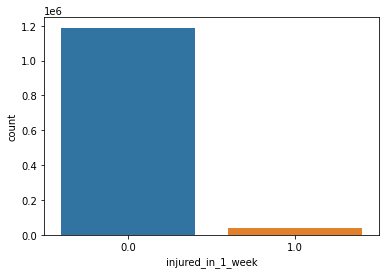

In [14]:
sns.countplot(x='injured_in_1_week',data=df_train)

<AxesSubplot:xlabel='injured_in_1_week', ylabel='count'>

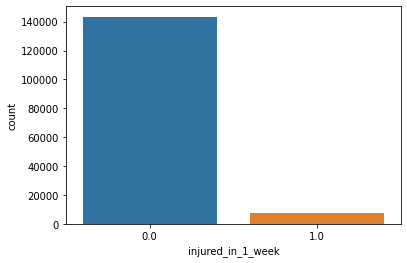

In [15]:
sns.countplot(x='injured_in_1_week',data=df_test)

# Dummy Classifier

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
scoring = ["accuracy", "balanced_accuracy"]
cv_result = cross_validate(dummy_clf, X_train, y_train, scoring=scoring)
print(f"Accuracy score of a dummy classifier: {cv_result['test_accuracy'].mean():.3f}")
print(
    f"Balanced accuracy score of a dummy classifier: "
    f"{cv_result['test_balanced_accuracy'].mean():.3f}"
)

Accuracy score of a dummy classifier: 0.970
Balanced accuracy score of a dummy classifier: 0.500


In [22]:
index = []
scores = {"Accuracy": [], "Balanced accuracy": []}

In [23]:
index += ["Dummy classifier"]
cv_result = cross_validate(dummy_clf, X_train, y_train, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.969544,0.5


# 1 Week Prediction (Non-Weighted)

In [25]:
lr_clf = LogisticRegression(max_iter=1000)


In [89]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
index += ["Logistic regression"]
cv_result = cross_validate(lr_clf, X_train, y_train, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.969544,0.500000
Logistic regression,0.968997,0.500379


In [27]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42, n_jobs=2)

index += ["Random forest"]
cv_result = cross_validate(rf_clf, X_train, y_train, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,Balanced accuracy
Dummy classifier,0.969544,0.500000
Logistic regression,0.968997,0.500379
Random forest,0.970186,0.657788


In [90]:
print(clf.coef_, clf.intercept_)

[[-0.13183338  0.09856454 -0.00761418  0.00032928 -0.01197866 -0.04943199
  -0.02449308]] [-0.16698742]


In [91]:
print('Train score: ' + str(clf.score(X_train, y_train)))
print('Test score: ' + str(clf.score(X_test, y_test)))

Train score: 0.9688929902546328
Test score: 0.9467248155782525


In [92]:
predictions = clf.predict(X_test)

In [93]:
# performance
print(f'Accuracy Score: {accuracy_score(y_test,predictions)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, predictions)}')
print(f'Area Under Curve: {roc_auc_score(y_test, predictions)}')
print(f'Recall score: {recall_score(y_test,predictions)}')

Accuracy Score: 0.9467248155782525
Confusion Matrix: 
[[142747    608]
 [  7430     92]]
Area Under Curve: 0.5039947851665156
Recall score: 0.012230789683594789


In [94]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97    143355
         1.0       0.13      0.01      0.02      7522

    accuracy                           0.95    150877
   macro avg       0.54      0.50      0.50    150877
weighted avg       0.91      0.95      0.93    150877



# Weighted Logistic Regression

In [100]:
# define class weights
w = {0:1, 1:19}

# define model
lg2 = LogisticRegression(random_state=13, class_weight=w)
# fit it
lg2.fit(X_train,y_train)
# test
y_pred = lg2.predict(X_test)

# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.6121476434446602
Confusion Matrix: 
[[86731 56624]
 [ 1894  5628]]
Area Under Curve: 0.6766069048886036
Recall score: 0.7482052645572986


In [99]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.10      0.18    143355
         1.0       0.05      0.98      0.10      7522

    accuracy                           0.14    150877
   macro avg       0.52      0.54      0.14    150877
weighted avg       0.94      0.14      0.17    150877



# Weights GridSearch

In [104]:
# define weight hyperparameter
w = [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:5}, {0:1, 1:10}, {0:1, 1:15}, {0:1, 1:20}]
hyperparam_grid = {"class_weight": w }

In [106]:
# define model
lg3 = LogisticRegression(random_state=13)
# define evaluation procedure
grid = GridSearchCV(lg3,hyperparam_grid,scoring="roc_auc", cv=100, n_jobs=-1, refit=True)
grid.fit(X_train,y_train)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le